# 3. Machine Learning Pipeline - Home Credit Default Risk: Modeling and Evaluation

### Imports 

In [85]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import shap
import pickle

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import category_encoders as ce

from src.utils import split_with_stratified_shuffle_split, get_classifier_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare Data

In [2]:
ROOTH_PATH = os.getcwd()
PROCESSED_DATA_PATH = os.path.join(ROOTH_PATH, "data/processed")

TARGET = 'TARGET'
RANDOM_STATE = 123456
VALIDATION_SIZE = 0.10
N_SPLITS = 2

In [3]:
train_info = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_info.csv')).drop(columns='Unnamed: 0')
train_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 633 entries, SK_ID_CURR to AMT_PAYMENT_sum
dtypes: float64(576), int64(41), object(16)
memory usage: 1.2+ GB


#### Split data on train_set and validation_test

In [4]:
df_train, df_validation = split_with_stratified_shuffle_split(train_info, TARGET, N_SPLITS, VALIDATION_SIZE, RANDOM_STATE)

CATEGORICAL_VARS = [var for var in df_train.columns if df_train[var].dtype=='O']
NUMERICAL_VARS = [var for var in df_train.columns if var not in CATEGORICAL_VARS and var!=TARGET and var!='SK_ID_CURR']
ALL_FEATURES = NUMERICAL_VARS + CATEGORICAL_VARS

X_train, Y_train, X_validation, Y_validation = df_train[ALL_FEATURES], df_train[TARGET], df_validation[ALL_FEATURES], df_validation[TARGET]
X_train.shape

24601
24601
Data Train info: 221407
Data Test info: 24601


(221407, 631)

## 1. Model Baseline

#### - Train a Logit Model

In [5]:
categorical_transformer = Pipeline(
    steps=[
        ('missing_imputation', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Missing')),
        ('target_encoder', ce.TargetEncoder()),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ('mean_imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('min_max_scaler', MinMaxScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, CATEGORICAL_VARS), 
        ('numeric_transformer', numeric_transformer, NUMERICAL_VARS),
    ]
)

logist_credit_risk_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier',  LogisticRegression(random_state=RANDOM_STATE))
    ]
)

logist_credit_risk_pipeline.fit(X_train[ALL_FEATURES], Y_train)
Y_validation_scores = logist_credit_risk_pipeline.predict_proba(X_validation[ALL_FEATURES])[:, 1]
Y_train_scores = logist_credit_risk_pipeline.predict_proba(X_train[ALL_FEATURES])[:, 1]

result_logist_model = get_classifier_metrics(Y_train, Y_train_scores, Y_validation, Y_validation_scores)
result_logist_model

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'roc_auc_train': 0.7597644455826024,
 'pr_auc_train': 0.2395118898096736,
 'roc_auc_validation': 0.751107631822047,
 'pr_auc_validation': 0.23072604692296897}

#### - Train a Random Forest

In [6]:
categorical_transformer = Pipeline(
    steps=[
        ('missing_imputation', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Missing')),
        ('target_encoder', ce.TargetEncoder()),
    ]
)

numeric_transformer = Pipeline(
    steps=[('mean_imputation', SimpleImputer(missing_values=np.nan, strategy='mean'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, CATEGORICAL_VARS), 
        ('numeric_transformer', numeric_transformer, NUMERICAL_VARS),
    ]
)


random_forest_credit_risk_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier',  RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

random_forest_credit_risk_pipeline.fit(X_train[ALL_FEATURES], Y_train)
Y_validation_scores = random_forest_credit_risk_pipeline.predict_proba(X_validation[ALL_FEATURES])[:, 1]
Y_train_scores = random_forest_credit_risk_pipeline.predict_proba(X_train[ALL_FEATURES])[:, 1]

result_random_forest_model = get_classifier_metrics(Y_train, Y_train_scores, Y_validation, Y_validation_scores)
result_random_forest_model

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


{'roc_auc_train': 1.0,
 'pr_auc_train': 1.0,
 'roc_auc_validation': 0.7017599317263739,
 'pr_auc_validation': 0.19308707130287867}

### - Train a LightGBM

In [7]:
lgbm_credit_risk_pipeline = Pipeline(
    steps=[
        ('target_encoder', ce.TargetEncoder()), 
        ('classifier',  lgbm.LGBMClassifier(random_state=RANDOM_STATE))
    ]
)

lgbm_credit_risk_pipeline.fit(X_train[ALL_FEATURES], Y_train)
Y_validation_scores = lgbm_credit_risk_pipeline.predict_proba(X_validation[ALL_FEATURES])[:, 1]
Y_train_scores = lgbm_credit_risk_pipeline.predict_proba(X_train[ALL_FEATURES])[:, 1]

result_lgbm_model = get_classifier_metrics(Y_train, Y_train_scores, Y_validation, Y_validation_scores)
result_lgbm_model 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


{'roc_auc_train': 0.8349866647190196,
 'pr_auc_train': 0.38448181541731075,
 'roc_auc_validation': 0.766715404915995,
 'pr_auc_validation': 0.258499999983835}

## 2. Forward Feature selection 

##### a. Get Feature Importance from Shap Values

In [14]:
preprocessor_data = ce.TargetEncoder()
preprocessor_data.fit(X_train[ALL_FEATURES], Y_train) 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


TargetEncoder(cols=['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'])

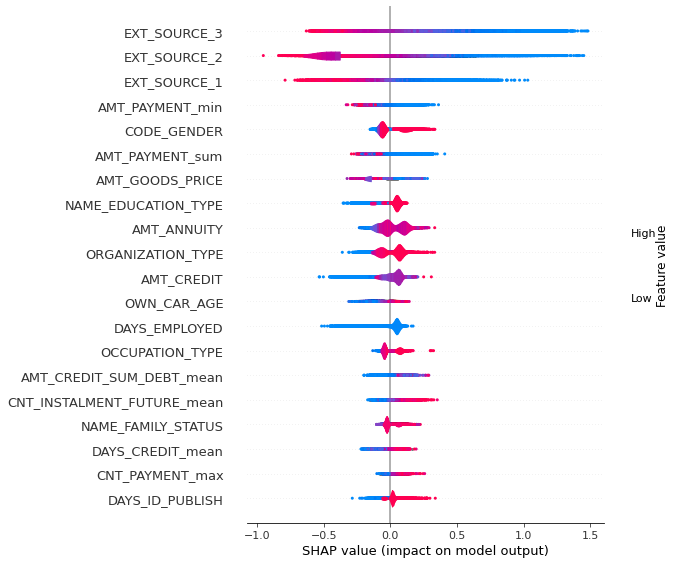

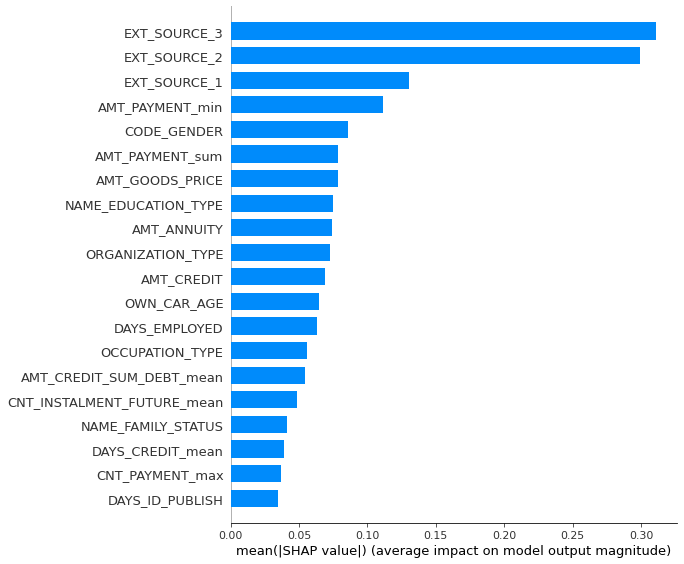

In [17]:
lgbm_credit_risk_pipeline.fit(X_train[ALL_FEATURES], Y_train)
shap_values = lgbm_credit_risk_pipeline.predict_proba(X_validation[ALL_FEATURES], pred_contrib=True)[:,:-1]
shap.summary_plot(shap_values, preprocessor_data.transform(X_validation[ALL_FEATURES]), plot_type='violin')
shap.summary_plot(shap_values, preprocessor_data.transform(X_validation[ALL_FEATURES]), plot_type='bar')

In [18]:
feature_names = X_validation[ALL_FEATURES].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head(20)

,col_name,feature_importance_vals
29,EXT_SOURCE_3,0.310642
28,EXT_SOURCE_2,0.299342
27,EXT_SOURCE_1,0.130650
613,AMT_PAYMENT_min,0.111577
616,CODE_GENDER,0.085507
614,AMT_PAYMENT_sum,0.078729
4,AMT_GOODS_PRICE,0.078425
621,NAME_EDUCATION_TYPE,0.074789
3,AMT_ANNUITY,0.073882
626,ORGANIZATION_TYPE,0.072793


##### b. Choose the feature set

In [19]:
feature_names = X_train[ALL_FEATURES].columns
range_ite = 10
set_features = range_ite
dict_feature_selection = {}

while set_features <= len(feature_names):
    print(f"test number features: {set_features}")
    feature_aux = list(shap_importance["col_name"])[0:set_features]
    
    lgbm_credit_risk_pipeline.fit(X_train[feature_aux], Y_train)
    
    Y_train_scores = lgbm_credit_risk_pipeline.predict_proba(X_train[feature_aux])[:, 1]
    Y_test_scores = lgbm_credit_risk_pipeline.predict_proba(X_validation[feature_aux])[:, 1]
    
    dict_feature_selection[set_features] = get_classifier_metrics(Y_train, Y_train_scores, Y_validation, Y_test_scores)
    print("{}".format(dict_feature_selection[set_features]))
    set_features = set_features + range_ite

test number features: 10
{'roc_auc_train': 0.7891292243740683, 'pr_auc_train': 0.2840038039257369, 'roc_auc_validation': 0.7429978008785354, 'pr_auc_validation': 0.22834852059879043}
test number features: 20
{'roc_auc_train': 0.8082948949285966, 'pr_auc_train': 0.31796402332172896, 'roc_auc_validation': 0.7534607385458992, 'pr_auc_validation': 0.24363760788116742}
test number features: 30
{'roc_auc_train': 0.8186233276888943, 'pr_auc_train': 0.3379466136912149, 'roc_auc_validation': 0.7597833296484634, 'pr_auc_validation': 0.24670108988947925}
test number features: 40
{'roc_auc_train': 0.8236874000000025, 'pr_auc_train': 0.3530761644957572, 'roc_auc_validation': 0.7645315127626748, 'pr_auc_validation': 0.25462826533493893}
test number features: 50
{'roc_auc_train': 0.8260863155370342, 'pr_auc_train': 0.3581381066104385, 'roc_auc_validation': 0.7665432290904783, 'pr_auc_validation': 0.256983829251812}
test number features: 60
{'roc_auc_train': 0.8270442550659706, 'pr_auc_train': 0.36050

Results - ROC AUC


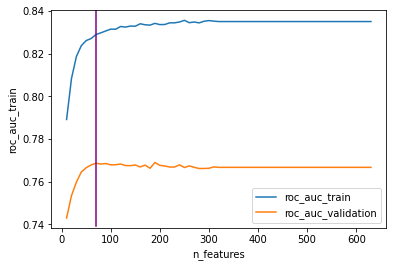

In [22]:
df_features = pd.DataFrame(dict_feature_selection).T.reset_index()
df_features = df_features.rename(columns={"index": "n_features"})

plt_x = sns.lineplot(data=df_features, x="n_features", y="roc_auc_train", label="roc_auc_train")
plt_x = sns.lineplot(data=df_features, x="n_features", y="roc_auc_validation", label="roc_auc_validation")
plt_x.axvline(70, 0.01, 1, c="purple", label="n_features")
print("Results - ROC AUC")

Results - PR AUC


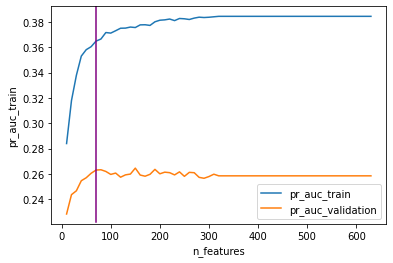

In [23]:
plt_x = sns.lineplot(data=df_features, x="n_features", y="pr_auc_train", label="pr_auc_train")
plt_x = sns.lineplot(data=df_features, x="n_features", y="pr_auc_validation", label="pr_auc_validation")
plt_x.axvline(70, 0.01, 1, c="purple", label="n_features")
print("Results - PR AUC")

## 3. Hyperparameter Tuning

In [24]:
FILTER_FEATURES = list(shap_importance['col_name'][0:70].values)
FILTER_FEATURES

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AMT_PAYMENT_min',
 'CODE_GENDER',
 'AMT_PAYMENT_sum',
 'AMT_GOODS_PRICE',
 'NAME_EDUCATION_TYPE',
 'AMT_ANNUITY',
 'ORGANIZATION_TYPE',
 'AMT_CREDIT',
 'OWN_CAR_AGE',
 'DAYS_EMPLOYED',
 'OCCUPATION_TYPE',
 'AMT_CREDIT_SUM_DEBT_mean',
 'CNT_INSTALMENT_FUTURE_mean',
 'NAME_FAMILY_STATUS',
 'DAYS_CREDIT_mean',
 'CNT_PAYMENT_max',
 'DAYS_ID_PUBLISH',
 'CNT_PAYMENT_mean',
 'AMT_DOWN_PAYMENT_sum',
 'DAYS_BIRTH',
 'FLAG_DOCUMENT_3',
 'AGE',
 'DAYS_CREDIT_max',
 'DAYS_ENTRY_PAYMENT_max',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_ENDDATE_FACT_max',
 'DAYS_CREDIT_ENDDATE_max',
 'AMT_CREDIT_MAX_OVERDUE_mean',
 'SK_DPD_DEF_mean_x',
 'CNT_DRAWINGS_ATM_CURRENT_mean',
 'DAYS_LAST_DUE_1ST_VERSION_max',
 'MONTHS_BALANCE_max_x',
 'CNT_PAYMENT_sum',
 'DAYS_INSTALMENT_max',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'SK_ID_PREV_sum_y',
 'AMT_CREDIT_SUM_sum',
 'NFLAG_INSURED_ON_APPROVAL_mean',
 'RATE_DOWN_PAYMENT_max',
 'AMT_PAYMENT_mean',
 'CNT_DRAWINGS_CURRENT_mean',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'SELLERPLACE_AREA_mean',
 'DAYS_ENTRY_PAYMENT_min',
 'NAME_INCOME_TYPE',
 'WALLSMATERIAL_MODE',
 'NAME_CONTRACT_TYPE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'TOTALAREA_MODE',
 'AMT_BALANCE_mean',
 'AMT_CREDIT_MAX_OVERDUE_sum',
 'CNT_DRAWINGS_CURRENT_max',
 'AMT_CREDIT_SUM_mean',
 'DAYS_INSTALMENT_min',
 'DAYS_LAST_DUE_mean',
 'NUM_INSTALMENT_VERSION_max',
 'AMT_CREDIT_sum',
 'NUM_INSTALMENT_NUMBER_mean',
 'CNT_INSTALMENT_mean',
 'NUM_INSTALMENT_VERSION_sum',
 'AMT_CREDIT_SUM_LIMIT_max',
 'SK_ID_PREV_sum_x',
 'AMT_CREDIT_SUM_max',
 'WEEKDAY_APPR_PROCESS_START',
 'NUM_INSTALMENT_NUMBER_max',
 'AMT_CREDIT_SUM_DEBT_sum',
 'AMT_GOODS_PRICE_min']

In [37]:
space = {
    "learning_rate": lambda: np.random.uniform(0.1, 0.5),
    "num_estimators": lambda: np.random.uniform(100.0, 200.0),
    "extra_params": {
        "num_leaves": lambda: np.random.choice(range(20,80)),
        "max_depth": lambda: np.random.choice(range(300, 500)),
        "min_data_in_leaf": lambda: np.random.randint(50, 100),
        "bagging_fraction": lambda: np.random.uniform(0.6, 0.8),
        "feature_fraction": lambda: np.random.uniform(0.6, 0.8),
        "objective": lambda: "binary",
        "seed": lambda: 123456,
        "verbose": lambda: -1,
        "boosting_type": lambda: "gbdt",
        "num_threads": lambda: 65*10,
        "n_jobs": lambda: 65*3,
        "seed": lambda: 123,
        "objetive": lambda: "binary",
        "is_unbalance": lambda: True
    }
}

random_parameters = {}
total_iteraction = 20

for i in range(total_iteraction):
    dic_prov = {}
    dic_prov["num_estimators"] = int(space["num_estimators"]())
    dic_prov["learning_rate"] = space["learning_rate"]()
    dic_prov["extra_params"] = {"num_leaves": 1}
    dic_prov["extra_params"]["num_leaves"]= space["extra_params"]["num_leaves"]()
    dic_prov["extra_params"]["max_depth"]= space["extra_params"]["max_depth"]()
    dic_prov["extra_params"]["min_data_in_leaf"]= space["extra_params"]["min_data_in_leaf"]()
    dic_prov["extra_params"]["bagging_fraction"]= space["extra_params"]["bagging_fraction"]()
    dic_prov["extra_params"]["feature_fraction"]= space["extra_params"]["feature_fraction"]()
    dic_prov["extra_params"]["num_threads"]= space["extra_params"]["num_threads"]()
    dic_prov["extra_params"]["objective"]= space["extra_params"]["objective"]()
    dic_prov["extra_params"]["seed"]= space["extra_params"]["seed"]()
    dic_prov["extra_params"]["verbose"]= space["extra_params"]["verbose"]()
    
    random_parameters[i] = dic_prov
    
tunning_logs = {}

for i in range(total_iteraction):

    print(f"iteraction - {i}")
    model_parameters = random_parameters[i]
    print(model_parameters)
    lgbm_credit_risk_pipeline = Pipeline(
        steps=[
            ('target_encoder', ce.TargetEncoder()), 
            ('classifier',  lgbm.LGBMClassifier(
                objective='binary',
                n_estimators=model_parameters['num_estimators'],
                num_leaves=model_parameters["extra_params"]["num_leaves"],
                learning_rate=model_parameters["learning_rate"],
                max_depth=model_parameters["extra_params"]["max_depth"],
                min_data_in_leaf=model_parameters["extra_params"]["min_data_in_leaf"],
                bagging_fraction=model_parameters["extra_params"]["bagging_fraction"],
                feature_fraction=model_parameters["extra_params"]["feature_fraction"],
                is_unbalance=True,
                random_state=RANDOM_STATE
            ))
        ]
    )

    lgbm_credit_risk_pipeline.fit(X_train[FILTER_FEATURES], Y_train)
    Y_validation_scores = lgbm_credit_risk_pipeline.predict_proba(X_validation[FILTER_FEATURES])[:, 1]    
    Y_train_scores = lgbm_credit_risk_pipeline.predict_proba(X_train[FILTER_FEATURES])[:, 1] 
    get_classifier_metrics(Y_train, Y_train_scores, Y_validation, Y_validation_scores)  

    
    tunning_logs[i] = get_classifier_metrics(Y_train, Y_train_scores, Y_validation, Y_validation_scores)
    tunning_logs[i]['model_parameters'] = model_parameters
    
    print(tunning_logs[i])
    
df_tuning_results = pd.DataFrame(tunning_logs).T

iteraction - 0
{'num_estimators': 145, 'learning_rate': 0.1382148266456527, 'extra_params': {'num_leaves': 67, 'max_depth': 350, 'min_data_in_leaf': 57, 'bagging_fraction': 0.7333569808338387, 'feature_fraction': 0.7956833139925654, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}


Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.7956833139925654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7956833139925654
[LightGBM] [Warning] bagging_fraction is set=0.7333569808338387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7333569808338387
{'roc_auc_train': 0.9166311247979887, 'pr_auc_train': 0.49280686509552557, 'roc_auc_validation': 0.764048583284406, 'pr_auc_validation': 0.25216895497807834, 'model_parameters': {'num_estimators': 145, 'learning_rate': 0.1382148266456527, 'extra_params': {'num_leaves': 67, 'max_depth': 350, 'min_data_in_leaf': 57, 'bagging_fraction': 0.7333569808338387, 'feature_fraction': 0.7956833139925654, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 1
{'num_estimators': 111, 'learning_rate': 0.40924453105933145, 'extra_params': {'num_leaves': 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.7350653901115234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7350653901115234
[LightGBM] [Warning] bagging_fraction is set=0.6575349756581734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6575349756581734
{'roc_auc_train': 0.9593945821077601, 'pr_auc_train': 0.6276683142503229, 'roc_auc_validation': 0.7287504906665918, 'pr_auc_validation': 0.21404098758488457, 'model_parameters': {'num_estimators': 111, 'learning_rate': 0.40924453105933145, 'extra_params': {'num_leaves': 74, 'max_depth': 417, 'min_data_in_leaf': 84, 'bagging_fraction': 0.6575349756581734, 'feature_fraction': 0.7350653901115234, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 2
{'num_estimators': 174, 'learning_rate': 0.267785620485668, 'extra_params': {'num_leaves': 7

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.6254319473856623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254319473856623
[LightGBM] [Warning] bagging_fraction is set=0.6328640338169527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6328640338169527
{'roc_auc_train': 0.9661591546921483, 'pr_auc_train': 0.6883524301965923, 'roc_auc_validation': 0.7441458326792968, 'pr_auc_validation': 0.223588099393653, 'model_parameters': {'num_estimators': 174, 'learning_rate': 0.267785620485668, 'extra_params': {'num_leaves': 70, 'max_depth': 367, 'min_data_in_leaf': 75, 'bagging_fraction': 0.6328640338169527, 'feature_fraction': 0.6254319473856623, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 3
{'num_estimators': 137, 'learning_rate': 0.48489609701455516, 'extra_params': {'num_leaves': 56,

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.6204983406308235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6204983406308235
[LightGBM] [Warning] bagging_fraction is set=0.7843427152313155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7843427152313155
{'roc_auc_train': 0.9587578969589039, 'pr_auc_train': 0.6215610135269556, 'roc_auc_validation': 0.7229300215370071, 'pr_auc_validation': 0.20789862660090075, 'model_parameters': {'num_estimators': 137, 'learning_rate': 0.48489609701455516, 'extra_params': {'num_leaves': 56, 'max_depth': 450, 'min_data_in_leaf': 71, 'bagging_fraction': 0.7843427152313155, 'feature_fraction': 0.6204983406308235, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 4
{'num_estimators': 194, 'learning_rate': 0.4035978017843962, 'extra_params': {'num_leaves': 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.6387039637787161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6387039637787161
[LightGBM] [Warning] bagging_fraction is set=0.7066610891270657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7066610891270657
{'roc_auc_train': 0.9527642189422519, 'pr_auc_train': 0.6087172705481435, 'roc_auc_validation': 0.7242282757992661, 'pr_auc_validation': 0.21849968150514754, 'model_parameters': {'num_estimators': 194, 'learning_rate': 0.4035978017843962, 'extra_params': {'num_leaves': 41, 'max_depth': 488, 'min_data_in_leaf': 81, 'bagging_fraction': 0.7066610891270657, 'feature_fraction': 0.6387039637787161, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 5
{'num_estimators': 116, 'learning_rate': 0.46744716779301587, 'extra_params': {'num_leaves': 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.6771559268990885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6771559268990885
[LightGBM] [Warning] bagging_fraction is set=0.6567243727920338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6567243727920338
{'roc_auc_train': 0.9084411566884811, 'pr_auc_train': 0.43763153224452905, 'roc_auc_validation': 0.7376408460817587, 'pr_auc_validation': 0.22062645299185243, 'model_parameters': {'num_estimators': 116, 'learning_rate': 0.46744716779301587, 'extra_params': {'num_leaves': 35, 'max_depth': 401, 'min_data_in_leaf': 92, 'bagging_fraction': 0.6567243727920338, 'feature_fraction': 0.6771559268990885, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 6
{'num_estimators': 193, 'learning_rate': 0.25599352822153487, 'extra_params': {'num_leaves'

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.6812652341605276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6812652341605276
[LightGBM] [Warning] bagging_fraction is set=0.7489201442177671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7489201442177671
{'roc_auc_train': 0.9521169594280952, 'pr_auc_train': 0.6166419849106761, 'roc_auc_validation': 0.7483201780137282, 'pr_auc_validation': 0.2327260240614525, 'model_parameters': {'num_estimators': 193, 'learning_rate': 0.25599352822153487, 'extra_params': {'num_leaves': 53, 'max_depth': 422, 'min_data_in_leaf': 69, 'bagging_fraction': 0.7489201442177671, 'feature_fraction': 0.6812652341605276, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 7
{'num_estimators': 170, 'learning_rate': 0.29598526618110677, 'extra_params': {'num_leaves': 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.6125848811643748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6125848811643748
[LightGBM] [Warning] bagging_fraction is set=0.7584917568284811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584917568284811
{'roc_auc_train': 0.9054786287728671, 'pr_auc_train': 0.44691466080928405, 'roc_auc_validation': 0.7487185002067313, 'pr_auc_validation': 0.24256029506013319, 'model_parameters': {'num_estimators': 170, 'learning_rate': 0.29598526618110677, 'extra_params': {'num_leaves': 31, 'max_depth': 335, 'min_data_in_leaf': 75, 'bagging_fraction': 0.7584917568284811, 'feature_fraction': 0.6125848811643748, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 8
{'num_estimators': 161, 'learning_rate': 0.25364307047063117, 'extra_params': {'num_leaves'

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.7451521618418194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7451521618418194
[LightGBM] [Warning] bagging_fraction is set=0.6319741099372829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6319741099372829
{'roc_auc_train': 0.9245049925306235, 'pr_auc_train': 0.4989396648738814, 'roc_auc_validation': 0.7510224233797538, 'pr_auc_validation': 0.2361811053954971, 'model_parameters': {'num_estimators': 161, 'learning_rate': 0.25364307047063117, 'extra_params': {'num_leaves': 44, 'max_depth': 379, 'min_data_in_leaf': 78, 'bagging_fraction': 0.6319741099372829, 'feature_fraction': 0.7451521618418194, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 9
{'num_estimators': 158, 'learning_rate': 0.1365851935495667, 'extra_params': {'num_leaves': 4

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.6088683426468732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6088683426468732
[LightGBM] [Warning] bagging_fraction is set=0.7862517481552572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7862517481552572
{'roc_auc_train': 0.8814419103367919, 'pr_auc_train': 0.40641775077722947, 'roc_auc_validation': 0.7642347193119914, 'pr_auc_validation': 0.25700835893035895, 'model_parameters': {'num_estimators': 158, 'learning_rate': 0.1365851935495667, 'extra_params': {'num_leaves': 42, 'max_depth': 316, 'min_data_in_leaf': 69, 'bagging_fraction': 0.7862517481552572, 'feature_fraction': 0.6088683426468732, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 10
{'num_estimators': 175, 'learning_rate': 0.404511285908128, 'extra_params': {'num_leaves': 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.6411177691829527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6411177691829527
[LightGBM] [Warning] bagging_fraction is set=0.7425803461961401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7425803461961401
{'roc_auc_train': 0.983384805662421, 'pr_auc_train': 0.8184555589620872, 'roc_auc_validation': 0.7127172319880553, 'pr_auc_validation': 0.1898912077609967, 'model_parameters': {'num_estimators': 175, 'learning_rate': 0.404511285908128, 'extra_params': {'num_leaves': 75, 'max_depth': 445, 'min_data_in_leaf': 71, 'bagging_fraction': 0.7425803461961401, 'feature_fraction': 0.6411177691829527, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 11
{'num_estimators': 186, 'learning_rate': 0.3100254454725778, 'extra_params': {'num_leaves': 67,

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.7962886425788713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7962886425788713
[LightGBM] [Warning] bagging_fraction is set=0.7703799176637258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7703799176637258
{'roc_auc_train': 0.9759236531891837, 'pr_auc_train': 0.7637608254073835, 'roc_auc_validation': 0.7339255175349713, 'pr_auc_validation': 0.21602865430214388, 'model_parameters': {'num_estimators': 186, 'learning_rate': 0.3100254454725778, 'extra_params': {'num_leaves': 67, 'max_depth': 305, 'min_data_in_leaf': 66, 'bagging_fraction': 0.7703799176637258, 'feature_fraction': 0.7962886425788713, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 12
{'num_estimators': 147, 'learning_rate': 0.11695654940497656, 'extra_params': {'num_leaves':

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.7306783557994561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7306783557994561
[LightGBM] [Warning] bagging_fraction is set=0.6504937038086371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6504937038086371
{'roc_auc_train': 0.8633903700727191, 'pr_auc_train': 0.3738747820943203, 'roc_auc_validation': 0.7647141754385496, 'pr_auc_validation': 0.26002016149209073, 'model_parameters': {'num_estimators': 147, 'learning_rate': 0.11695654940497656, 'extra_params': {'num_leaves': 38, 'max_depth': 359, 'min_data_in_leaf': 84, 'bagging_fraction': 0.6504937038086371, 'feature_fraction': 0.7306783557994561, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 13
{'num_estimators': 119, 'learning_rate': 0.17509726394809216, 'extra_params': {'num_leaves'

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.7365978389389056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7365978389389056
[LightGBM] [Warning] bagging_fraction is set=0.6536210381562294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6536210381562294
{'roc_auc_train': 0.8495614067791225, 'pr_auc_train': 0.35021890556511037, 'roc_auc_validation': 0.764295302581257, 'pr_auc_validation': 0.25962092481798643, 'model_parameters': {'num_estimators': 119, 'learning_rate': 0.17509726394809216, 'extra_params': {'num_leaves': 27, 'max_depth': 422, 'min_data_in_leaf': 97, 'bagging_fraction': 0.6536210381562294, 'feature_fraction': 0.7365978389389056, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 14
{'num_estimators': 142, 'learning_rate': 0.1261689397241983, 'extra_params': {'num_leaves':

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.6116389811545921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6116389811545921
[LightGBM] [Warning] bagging_fraction is set=0.7812134356069105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7812134356069105
{'roc_auc_train': 0.8602938938743878, 'pr_auc_train': 0.3731556024735268, 'roc_auc_validation': 0.7672635265340692, 'pr_auc_validation': 0.26210975151862165, 'model_parameters': {'num_estimators': 142, 'learning_rate': 0.1261689397241983, 'extra_params': {'num_leaves': 36, 'max_depth': 375, 'min_data_in_leaf': 69, 'bagging_fraction': 0.7812134356069105, 'feature_fraction': 0.6116389811545921, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 15
{'num_estimators': 109, 'learning_rate': 0.43854532611753094, 'extra_params': {'num_leaves':

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.6048748076104383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6048748076104383
[LightGBM] [Warning] bagging_fraction is set=0.7572866381518288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572866381518288
{'roc_auc_train': 0.8910884167952795, 'pr_auc_train': 0.40423222307512935, 'roc_auc_validation': 0.7418140781624367, 'pr_auc_validation': 0.22113395409730335, 'model_parameters': {'num_estimators': 109, 'learning_rate': 0.43854532611753094, 'extra_params': {'num_leaves': 31, 'max_depth': 365, 'min_data_in_leaf': 64, 'bagging_fraction': 0.7572866381518288, 'feature_fraction': 0.6048748076104383, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 16
{'num_estimators': 181, 'learning_rate': 0.10884649836959648, 'extra_params': {'num_leaves

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] feature_fraction is set=0.7646495593247034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7646495593247034
[LightGBM] [Warning] bagging_fraction is set=0.636892550510459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.636892550510459
{'roc_auc_train': 0.9255989056593776, 'pr_auc_train': 0.5198046712663476, 'roc_auc_validation': 0.765182499027573, 'pr_auc_validation': 0.2524600082580041, 'model_parameters': {'num_estimators': 181, 'learning_rate': 0.10884649836959648, 'extra_params': {'num_leaves': 74, 'max_depth': 445, 'min_data_in_leaf': 67, 'bagging_fraction': 0.636892550510459, 'feature_fraction': 0.7646495593247034, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 17
{'num_estimators': 143, 'learning_rate': 0.3189654975551317, 'extra_params': {'num_leaves': 75, 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.7111718572813385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7111718572813385
[LightGBM] [Warning] bagging_fraction is set=0.6309204522083798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309204522083798
{'roc_auc_train': 0.9673552655197013, 'pr_auc_train': 0.6902953935209971, 'roc_auc_validation': 0.7355029981036836, 'pr_auc_validation': 0.2199991104724895, 'model_parameters': {'num_estimators': 143, 'learning_rate': 0.3189654975551317, 'extra_params': {'num_leaves': 75, 'max_depth': 358, 'min_data_in_leaf': 74, 'bagging_fraction': 0.6309204522083798, 'feature_fraction': 0.7111718572813385, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 18
{'num_estimators': 122, 'learning_rate': 0.4484992538540893, 'extra_params': {'num_leaves': 4

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.7411001167494979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7411001167494979
[LightGBM] [Warning] bagging_fraction is set=0.7047606889983696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047606889983696
{'roc_auc_train': 0.9251672676490046, 'pr_auc_train': 0.48254802506796113, 'roc_auc_validation': 0.7313321929161882, 'pr_auc_validation': 0.21650924909283048, 'model_parameters': {'num_estimators': 122, 'learning_rate': 0.4484992538540893, 'extra_params': {'num_leaves': 40, 'max_depth': 392, 'min_data_in_leaf': 53, 'bagging_fraction': 0.7047606889983696, 'feature_fraction': 0.7411001167494979, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}
iteraction - 19
{'num_estimators': 191, 'learning_rate': 0.15416712896607027, 'extra_params': {'num_leaves'

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.7199198264369358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7199198264369358
[LightGBM] [Warning] bagging_fraction is set=0.7968496971018018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968496971018018
{'roc_auc_train': 0.8938079734547295, 'pr_auc_train': 0.4325447965834761, 'roc_auc_validation': 0.76332830810589, 'pr_auc_validation': 0.25406834933777833, 'model_parameters': {'num_estimators': 191, 'learning_rate': 0.15416712896607027, 'extra_params': {'num_leaves': 38, 'max_depth': 398, 'min_data_in_leaf': 97, 'bagging_fraction': 0.7968496971018018, 'feature_fraction': 0.7199198264369358, 'num_threads': 650, 'objective': 'binary', 'seed': 123, 'verbose': -1}}}


In [38]:
df_tuning_results.sort_values('roc_auc_validation', ascending=False)

,roc_auc_train,pr_auc_train,roc_auc_validation,pr_auc_validation,model_parameters
14,0.860294,0.373156,0.767264,0.26211,"{'num_estimators': 142, 'learning_rate': 0.126..."
16,0.925599,0.519805,0.765182,0.25246,"{'num_estimators': 181, 'learning_rate': 0.108..."
12,0.86339,0.373875,0.764714,0.26002,"{'num_estimators': 147, 'learning_rate': 0.116..."
13,0.849561,0.350219,0.764295,0.259621,"{'num_estimators': 119, 'learning_rate': 0.175..."
9,0.881442,0.406418,0.764235,0.257008,"{'num_estimators': 158, 'learning_rate': 0.136..."
0,0.916631,0.492807,0.764049,0.252169,"{'num_estimators': 145, 'learning_rate': 0.138..."
19,0.893808,0.432545,0.763328,0.254068,"{'num_estimators': 191, 'learning_rate': 0.154..."
8,0.924505,0.49894,0.751022,0.236181,"{'num_estimators': 161, 'learning_rate': 0.253..."
7,0.905479,0.446915,0.748719,0.24256,"{'num_estimators': 170, 'learning_rate': 0.295..."
6,0.952117,0.616642,0.74832,0.232726,"{'num_estimators': 193, 'learning_rate': 0.255..."


In [42]:
tunning_logs[14]

{'roc_auc_train': 0.8602938938743878,
 'pr_auc_train': 0.3731556024735268,
 'roc_auc_validation': 0.7672635265340692,
 'pr_auc_validation': 0.26210975151862165,
 'model_parameters': {'num_estimators': 142,
  'learning_rate': 0.1261689397241983,
  'extra_params': {'num_leaves': 36,
   'max_depth': 375,
   'min_data_in_leaf': 69,
   'bagging_fraction': 0.7812134356069105,
   'feature_fraction': 0.6116389811545921,
   'num_threads': 650,
   'objective': 'binary',
   'seed': 123,
   'verbose': -1}}}

## 4. Evaluation 

#### Final LightGBM Model 

In [43]:
FILTER_FEATURES = [
    'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'AMT_PAYMENT_min', 'CODE_GENDER', 'AMT_PAYMENT_sum', 'AMT_GOODS_PRICE', 'NAME_EDUCATION_TYPE', 
    'AMT_ANNUITY', 'ORGANIZATION_TYPE', 'AMT_CREDIT', 'OWN_CAR_AGE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'AMT_CREDIT_SUM_DEBT_mean', 'CNT_INSTALMENT_FUTURE_mean', 
    'NAME_FAMILY_STATUS', 'DAYS_CREDIT_mean', 'CNT_PAYMENT_max', 'DAYS_ID_PUBLISH', 'CNT_PAYMENT_mean', 'AMT_DOWN_PAYMENT_sum', 'DAYS_BIRTH', 'FLAG_DOCUMENT_3', 
    'AGE', 'DAYS_CREDIT_max', 'DAYS_ENTRY_PAYMENT_max', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_ENDDATE_FACT_max', 'DAYS_CREDIT_ENDDATE_max', 'AMT_CREDIT_MAX_OVERDUE_mean', 
    'SK_DPD_DEF_mean_x', 'CNT_DRAWINGS_ATM_CURRENT_mean', 'DAYS_LAST_DUE_1ST_VERSION_max', 'MONTHS_BALANCE_max_x', 'CNT_PAYMENT_sum', 'DAYS_INSTALMENT_max', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'SK_ID_PREV_sum_y', 'AMT_CREDIT_SUM_sum', 'NFLAG_INSURED_ON_APPROVAL_mean', 'RATE_DOWN_PAYMENT_max', 'AMT_PAYMENT_mean', 'CNT_DRAWINGS_CURRENT_mean', 'AMT_REQ_CREDIT_BUREAU_QRT', 
    'SELLERPLACE_AREA_mean', 'DAYS_ENTRY_PAYMENT_min', 'NAME_INCOME_TYPE', 'WALLSMATERIAL_MODE', 'NAME_CONTRACT_TYPE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'TOTALAREA_MODE', 'AMT_BALANCE_mean', 
    'AMT_CREDIT_MAX_OVERDUE_sum', 'CNT_DRAWINGS_CURRENT_max', 'AMT_CREDIT_SUM_mean', 'DAYS_INSTALMENT_min', 'DAYS_LAST_DUE_mean', 'NUM_INSTALMENT_VERSION_max', 'AMT_CREDIT_sum', 
    'NUM_INSTALMENT_NUMBER_mean', 'CNT_INSTALMENT_mean', 'NUM_INSTALMENT_VERSION_sum', 'AMT_CREDIT_SUM_LIMIT_max', 'SK_ID_PREV_sum_x', 'AMT_CREDIT_SUM_max', 'WEEKDAY_APPR_PROCESS_START',
    'NUM_INSTALMENT_NUMBER_max', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_GOODS_PRICE_min'
]

PARAMETERS = {
    'num_estimators': 142,
    'learning_rate': 0.1261689397241983,
    'extra_params': {
        'num_leaves': 36,
        'max_depth': 375,
        'min_data_in_leaf': 69,
        'bagging_fraction': 0.7812134356069105,
        'feature_fraction': 0.6116389811545921,
        'num_threads': 650,
        'objective': 'binary',
        'seed': 123,
        'verbose': -1
    }
}

In [46]:
train_info = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_info.csv')).drop(columns='Unnamed: 0')
train_info.info()

CATEGORICAL_VARS = [var for var in train_info.columns if df_train[var].dtype=='O']
NUMERICAL_VARS = [var for var in train_info.columns if var not in CATEGORICAL_VARS and var!=TARGET and var!='SK_ID_CURR']
ALL_FEATURES = NUMERICAL_VARS + CATEGORICAL_VARS

X_train, Y_train = train_info[ALL_FEATURES], train_info[TARGET]

test_info = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'test_info.csv')).drop(columns='Unnamed: 0')
X_test, Y_test = test_info[ALL_FEATURES], test_info[TARGET]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 633 entries, SK_ID_CURR to AMT_PAYMENT_sum
dtypes: float64(576), int64(41), object(16)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Columns: 631 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE
dtypes: float64(576), int64(39), object(16)
memory usage: 296.1+ MB


In [47]:
lgbm_credit_risk_pipeline = Pipeline(
    steps=[
        ('target_encoder', ce.TargetEncoder()), 
        ('classifier',  lgbm.LGBMClassifier(
            objective='binary',
            n_estimators=PARAMETERS['num_estimators'],
            num_leaves=PARAMETERS["extra_params"]["num_leaves"],
            learning_rate=PARAMETERS["learning_rate"],
            max_depth=PARAMETERS["extra_params"]["max_depth"],
            min_data_in_leaf=PARAMETERS["extra_params"]["min_data_in_leaf"],
            bagging_fraction=PARAMETERS["extra_params"]["bagging_fraction"],
            feature_fraction=PARAMETERS["extra_params"]["feature_fraction"],
            is_unbalance=True)
        )
    ]
)

lgbm_credit_risk_pipeline.fit(X_train[FILTER_FEATURES], Y_train)
Y_test_scores = lgbm_credit_risk_pipeline.predict_proba(X_test[FILTER_FEATURES])[:, 1]    
Y_train_scores = lgbm_credit_risk_pipeline.predict_proba(X_train[FILTER_FEATURES])[:, 1] 
metrics = get_classifier_metrics(Y_train, Y_train_scores, Y_test, Y_test_scores)  

final_model = {
    "model_parameters": PARAMETERS,
    "roc_auc_train": metrics["roc_auc_train"],
    "roc_auc_validation": metrics["roc_auc_validation"],
    "pr_auc_train": metrics["pr_auc_train"],
    "pr_auc_validation": metrics["pr_auc_validation"],
}
    
final_model

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


{'model_parameters': {'num_estimators': 142,
  'learning_rate': 0.1261689397241983,
  'extra_params': {'num_leaves': 36,
   'max_depth': 375,
   'min_data_in_leaf': 69,
   'bagging_fraction': 0.7812134356069105,
   'feature_fraction': 0.6116389811545921,
   'num_threads': 650,
   'objective': 'binary',
   'seed': 123,
   'verbose': -1}},
 'roc_auc_train': 0.854017589315491,
 'roc_auc_validation': 0.7782288784589513,
 'pr_auc_train': 0.36076795834199077,
 'pr_auc_validation': 0.26815715563579834}

In [86]:
with open('lgbm_credit_risk_pipeline.pickle', 'wb') as handle:
    pickle.dump(lgbm_credit_risk_pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_scores)
df_metrics_aux = pd.DataFrame({
    "thresholds": list(thresholds) + [1.0],
    "precision": precision,
    "recall": recall,
})

df_scores = X_test[["AMT_CREDIT"]]
df_scores['prediction'] = Y_test_scores
df_scores['Success'] = Y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Recall-Thresholds Curve')

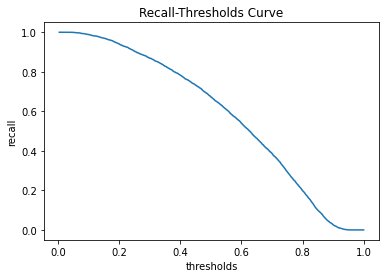

In [52]:
sns.lineplot(data=df_metrics_aux, x="thresholds", y="recall").set_title("Recall-Thresholds Curve")

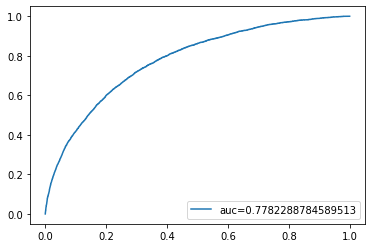

In [70]:
fpr, tpr, _ = metrics.roc_curve(Y_test.values, Y_test_scores)
auc = metrics.roc_auc_score(Y_test.values, Y_test_scores)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [73]:
preprocessor_data_final = ce.TargetEncoder()
preprocessor_data_final.fit(X_train[FILTER_FEATURES], Y_train) 

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


TargetEncoder(cols=['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE',
                    'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE',
                    'WALLSMATERIAL_MODE', 'NAME_CONTRACT_TYPE',
                    'WEEKDAY_APPR_PROCESS_START'])

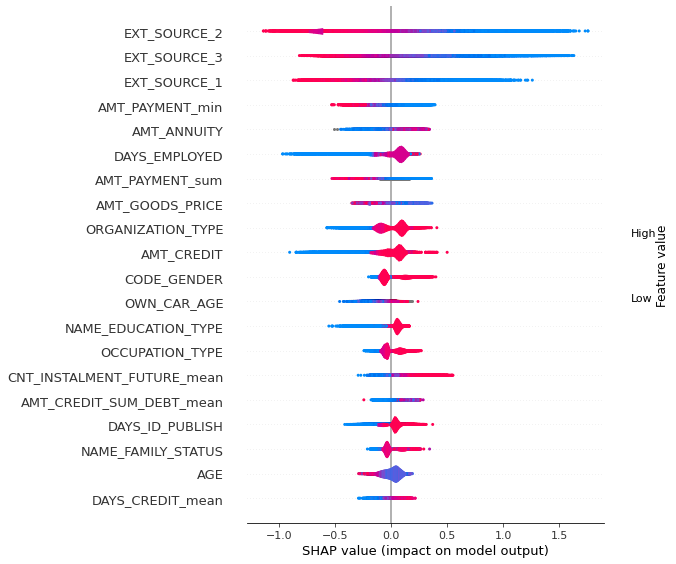

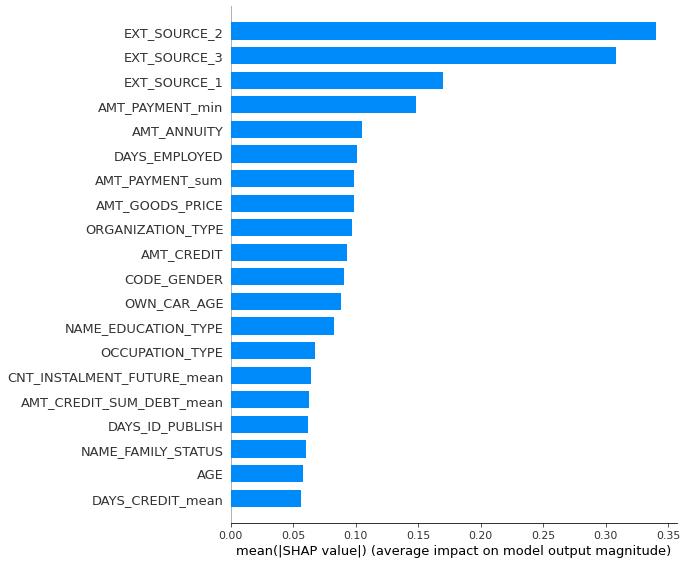

In [74]:
shap_values = lgbm_credit_risk_pipeline.predict_proba(X_test[FILTER_FEATURES], pred_contrib=True)[:,:-1]
shap.summary_plot(shap_values, preprocessor_data_final.transform(X_test[FILTER_FEATURES]), plot_type='violin')
shap.summary_plot(shap_values, preprocessor_data_final.transform(X_test[FILTER_FEATURES]), plot_type='bar')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


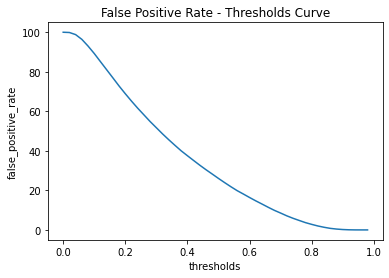

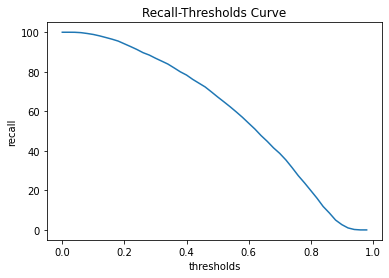

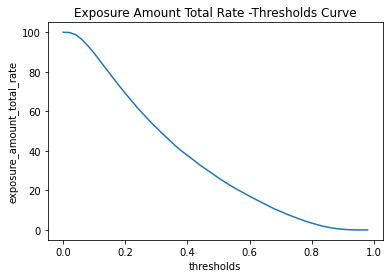

In [84]:
count_non_success = df_scores['Success'][df_scores['Success']==0].count()
count_success = df_scores['Success'][df_scores['Success']==1].count()
exposure_amount_total = df_scores["AMT_CREDIT"].sum()

threshold_v = []
recall_v = []
fpr_v = []
true_positives_v = []
exposure_amount_v = []
threshold_metrics = pd.DataFrame()


for i in range(0, 50, 1):
    threshold = i/50
    df_scores["clasification"] = np.where(df_scores["prediction"]>threshold, 1, 0)
    recall = df_scores["clasification"][df_scores["clasification"]==1][df_scores['Success']==1].sum()/df_scores['Success'].sum()*100
    true_positives = df_scores["clasification"][df_scores["clasification"]==1][df_scores['Success']==1].sum()
    false_positive_rate = df_scores["clasification"][df_scores["clasification"]==1][df_scores['Success']==0].count()/count_non_success*100
    exposure_amount = df_scores["AMT_CREDIT"][df_scores["clasification"]==1].sum()*100
    threshold_v.append(threshold)
    recall_v.append(recall)
    fpr_v.append(false_positive_rate)
    true_positives_v.append(true_positives)
    exposure_amount_v.append(exposure_amount)
    
threshold_metrics["thresholds"] = threshold_v
threshold_metrics["recall"] = recall_v
threshold_metrics["false_positive_rate"] = fpr_v
threshold_metrics["true_positives"] = true_positives_v
threshold_metrics["true_positives_rate"] = true_positives_v/count_success*100
threshold_metrics["exposure_amount"] = exposure_amount_v
threshold_metrics["exposure_amount_total_rate"] = exposure_amount_v/exposure_amount_total

extremely_high_treament = 0.82
high_treament = 0.36
plt_x = sns.lineplot(data=threshold_metrics, x="thresholds", y="false_positive_rate")
plt_x.set_title("False Positive Rate - Thresholds Curve")
plt.show()

plt_x = sns.lineplot(data=threshold_metrics, x="thresholds", y="recall")
plt_x.set_title("Recall-Thresholds Curve")
plt.show()

plt_x = sns.lineplot(data=threshold_metrics.astype({}), x="thresholds", y="exposure_amount_total_rate")
plt_x.set_title("Exposure Amount Total Rate -Thresholds Curve")
plt.show()